### Chargement du dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

airpass= pd.read_csv('AirPassengers.csv',index_col="Month",parse_dates=True)
display(airpass)
airpass.info()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


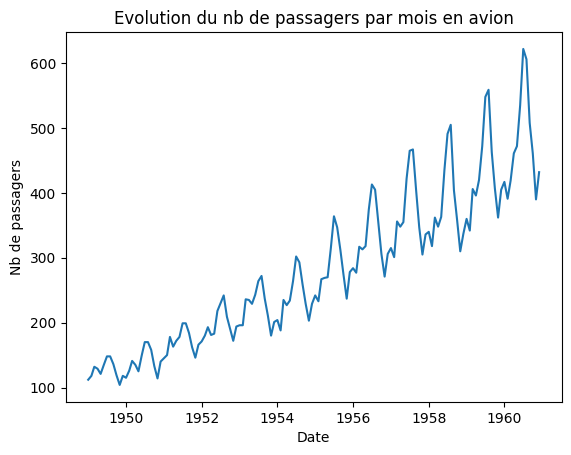

In [4]:
plt.plot(airpass)
plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.title("Evolution du nb de passagers par mois en avion")
plt.show()

### Décomposition en tendance, saisonnalité et résidus

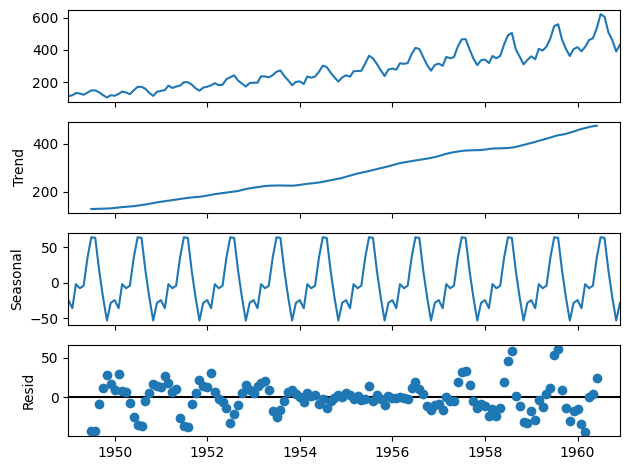

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_passengers = seasonal_decompose(airpass)
seasonal_passengers.plot()
plt.show()

# Modèle additif => pas terrible d'après les résidus

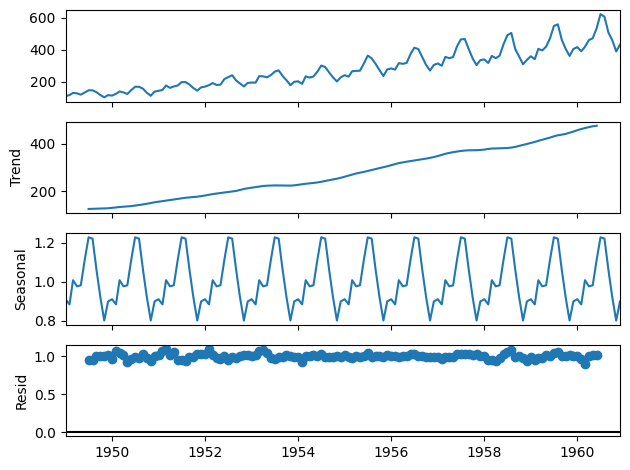

In [ ]:
seasonal_passengers = seasonal_decompose(airpass,model='multiplicative')
seasonal_passengers.plot()
plt.show()

# Modèle multiplicatif => bien mieux

On est donc sur un modèle multiplicatif à tendance linéaire croissante et de saisonnalité **s=12** (annuelle)

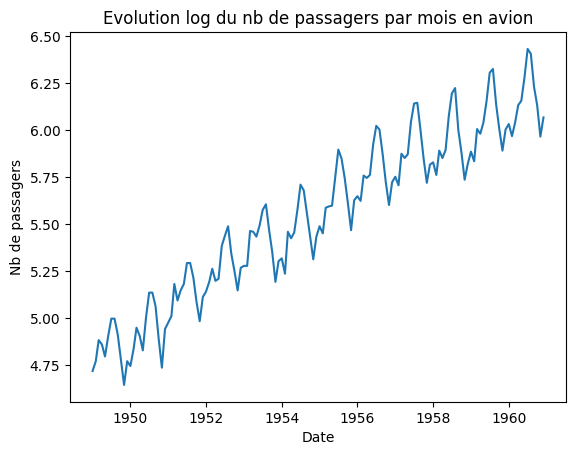

In [7]:
# Modèle multiplicatif => Transformation logarithmique de la série temporelle
airpasslog = np.log(airpass)

plt.plot(airpasslog)
plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.title("Evolution log du nb de passagers par mois en avion")
plt.show()

### Stationnarisation de la série par différenciation

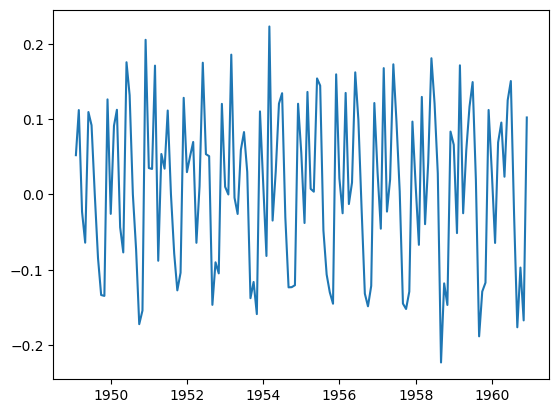

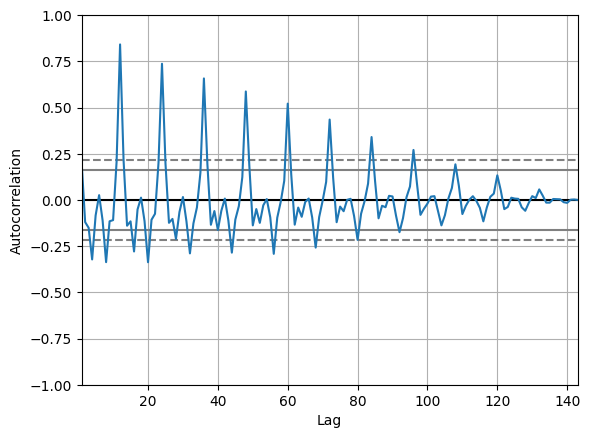

In [ ]:
from pandas.plotting import autocorrelation_plot

# On commence par une différenciation d'ordre 1 pour supprimer la tendance linéaire
airpasslog_1 = airpasslog.diff(1).dropna()
plt.plot(airpasslog_1)
plt.show()
autocorrelation_plot(airpasslog_1)
plt.show()

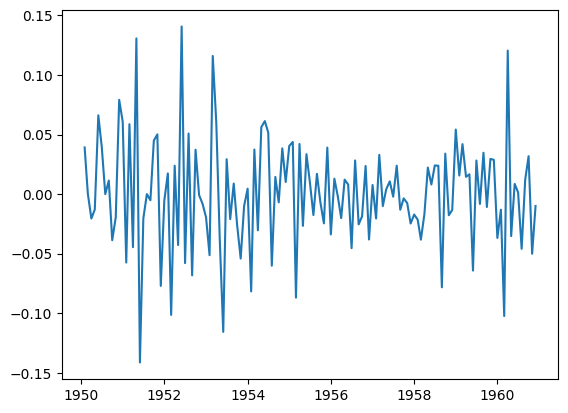

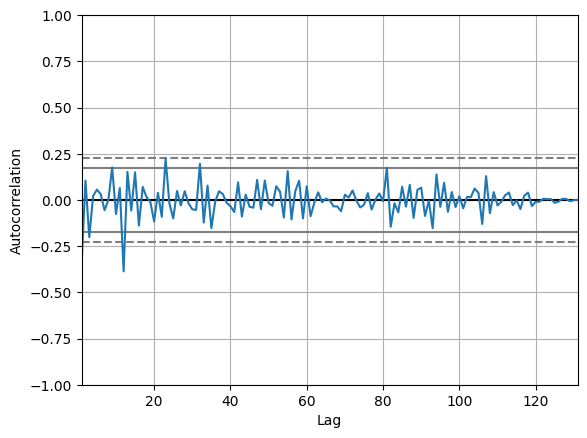

In [14]:
from pandas.plotting import autocorrelation_plot

# On ajoute une différenciation saisonnière d'ordre 1 pour supprimer la saisonnalité
airpasslog_2 = airpasslog_1.diff(12).dropna()
plt.plot(airpasslog_2)
plt.show()
autocorrelation_plot(airpasslog_2)
plt.show()

In [15]:
# Vérification de la stationnarité de la série doublement différenciée par test augmenté de Dickey-Fuller (ADF)
import statsmodels.api as sm
_, p_value,_,_,_,_ = sm.tsa.stattools.adfuller(airpasslog_2)
print(p_value)
# p-valeur bien inférieure à 0.05, on peut considérer la série comme stationnaire.

0.00024859123113840924


La double différenciation d'ordre 1 (=> **d= 1 et D=1**) permet de stationnariser la série

### Modélisation SARIMA

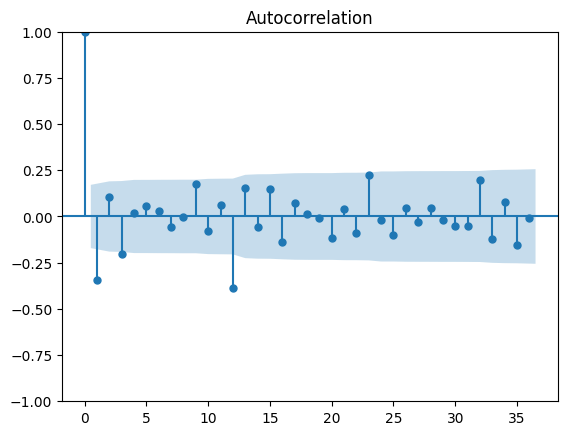

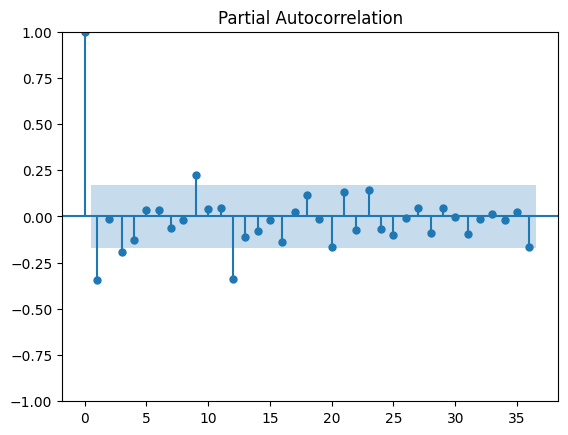

In [17]:
# On a déjà déterminé s=12 d=1 et D=1
# On va déterminer les ordres ARMA simples (p,q) et saisonniers (P,Q) par ACF et PACF

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Autocorrélation simple
plot_acf(airpasslog_2,lags=36)
plt.show()

# Autocorrélation partielle
plot_pacf(airpasslog_2,lags=36)
plt.show()


Pour l'ACF comme la PACF, on tend vers 0 sans coupure nette => ARMA(p,q) on choisit arbitrairement **p=1 et q=1**


Pour les pics saisonniers (12,24,36), pour l'ACF coupure nette après le 1er pic (12), pour la PACF pas de coupure nette  => **MA(1)**, soit **P=0 et Q=1**

On part donc sur un modèle SARIMA(p,d,q)(P,D,Q)s = **SARIMA(1,1,1)(0,1,1)12**

### Entraînement et affinement des paramètres

In [18]:
# Série à entraîner = après transfo log, avant stationnarisation (SARIMA le fait)
sarima = sm.tsa.SARIMAX(airpasslog,order=(1,1,1),seasonal_order=(0,1,1,12))
sarima_fitted = sarima.fit()

sarima_fitted.summary()

d:\Sources\DS-Machine-Learning\Series-temporelles\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Sources\DS-Machine-Learning\Series-temporelles\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Thu, 17 Apr 2025   AIC                           -481.893
Time:                                    21:15:14   BIC                           -470.392
Sample:                                01-01-1949   HQIC                          -477.220
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1968      0.199      0.989      0.323      -0.193       0.587
ma.L1         -0.5790      0.172     -3.376      0.001      -0.915      -0.243
ma.S.L12      -0.5642      0.104     -5.410      0.000      -0.769      -0.360
sigma2         0.0013      0.000      8.590      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.53
Prob(Q):                              0.88   Prob(JB):                         0.17
Heteroskedasticity (H):               0.60   Skew:                            -0.01
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La p-value du coefficient p est > 0.05, on peut le passer à 0

In [19]:
sarima = sm.tsa.SARIMAX(airpasslog,order=(0,1,1),seasonal_order=(0,1,1,12))
sarima_fitted = sarima.fit()

sarima_fitted.summary()

d:\Sources\DS-Machine-Learning\Series-temporelles\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Sources\DS-Machine-Learning\Series-temporelles\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Thu, 17 Apr 2025   AIC                           -483.393
Time:                                    21:17:06   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4017      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5571      0.096     -5.786      0.000      -0.746      -0.368
sigma2         0.0013      0.000      9.122      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.84   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Les p-value restantes sont très faibles, les coefficients P=1 et Q=1 sont bien significatifs.

De plus, on ne peut rejeter l'hypothès que les résidus correspondent à un bruit blanc et suivent une distribution normale ,d'après les Prob(Q) et Prob(JB) > 0.05.

Le modèle **SARIMA(0,1,1)(0,1,1)12** offre donc satisfaction

### Prédiction

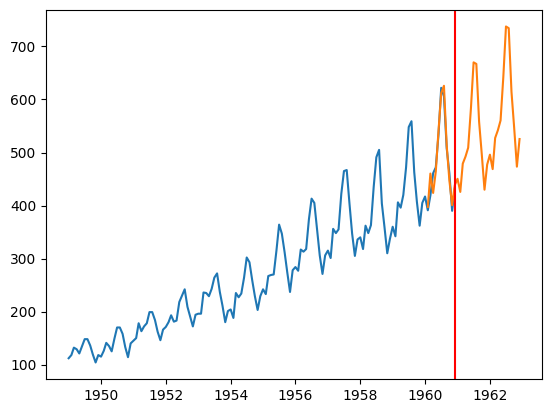

In [ ]:
import datetime

# Prédiction sur les 12 derniers mois et les 24 mois suivants
airpasslog_pred = sarima_fitted.predict(len(airpasslog)-11, len(airpasslog)+23)
# On abandonne l'échelle log
airpass_pred = np.exp(airpasslog_pred)
# On concatène la série réelle et la série prédite
airpass_concat = pd.concat([airpass,airpass_pred])

# Affichage concaténation réel / prédit
plt.plot(airpass_concat)
plt.axvline(x=datetime.date(1960,12,1),color="red") # Barre verticale
plt.show()

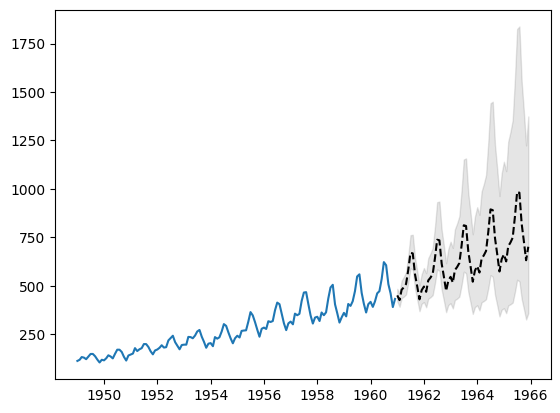

In [41]:
#Prédiction sur 5 ans avec intervalle de confiance
airpasslog_pred = sarima_fitted.get_forecast(steps =60).summary_frame()
# On abandonne l'échelle log
airpass_pred = np.exp(airpasslog_pred)

# On affiche la série réelle
plt.plot(airpass)

# On affiche la série prédite
plt.plot(airpass_pred['mean'], 'k--') #Visualisation de la moyenne
plt.fill_between(airpass_pred.index,airpass_pred['mean_ci_lower'], airpass_pred['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance
plt.show()
